### 1B Parameter QLORA TRAINING

* This is an attempt to train a 1B Parameter LLM using QLORA.

#### Check CUDA Availability

* We first need to check to ensure that CUDA is available.  We can start with the nvidia-smi shell tool.

In [1]:
!nvidia-smi

Wed Jan 17 19:38:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070        Off | 00000000:01:00.0 Off |                  N/A |
| 27%   32C    P8               5W / 151W |   5106MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Check Torch and GPU Specifications

* We need to ensure that torch is available within this kernel.
* we have developed a utility to check the GPU availability which we can import with sys

In [27]:
import sys
sys.path.append('./../utils/')
from specs import show_torch_and_gpu_stats

show_torch_and_gpu_stats()

2.1.2+cu121
GPU is available.
Current GPU device: 0
GPU Name: NVIDIA GeForce GTX 1070
GPU Memory Capacity: 8.501919744 GB


### Get Dataset for Training

* We want to use a custom dataset, starting with our own CSV file, rather than using the dataset tools available on HuggingFace. We're doing it this way because we want to understand how to be able to fundamentally fine tune a language model according to our own custom datasets, not optimize against publicly available datasets.
* That being said, we can use a sample dataset to start off with and transfer this into our own CSV file. The sample dataset we draw from is here: https://huggingface.co/datasets/Stevross/mmlu/viewer/abstract_algebra/dev

#### What the MMLU Dataset Includes

The MMLU dataset is a part of an LLM benchmark which is designed to measure LLM performance. The dataset includes various detailed questions, possible choices, and the correct answer. This format is typical for multiple-choice questions (MCQs), which are common in language understanding tasks. The components of MMLU include:

* Question: The main body of the text presenting a scenario or asking a question.
* Choices: A list of possible answers from which the correct one must be selected.
* Answer: The correct choice, often indicated by an index or key that corresponds to the correct option in the choices list.

The idea behind this format is that it is supposed to mimic real-world tasks, with the idea that in real-life, a person might take a test to get certified in something, and that test might be multiple-choice. Alternative open-ended essay based testing would be a different kind of benchmark that might include some kind of subjective assessment, as ELO Scores measure.

#### What Our Dataset Needs to Include

So to train a language model, you really want to bias it toward a set of answers to questions, so an input format like the following would suffice:

```
question	answer
What is the definition of a group in abstract algebra?	A set with an operation that is associative, has an identity element, and every element has an inverse.
```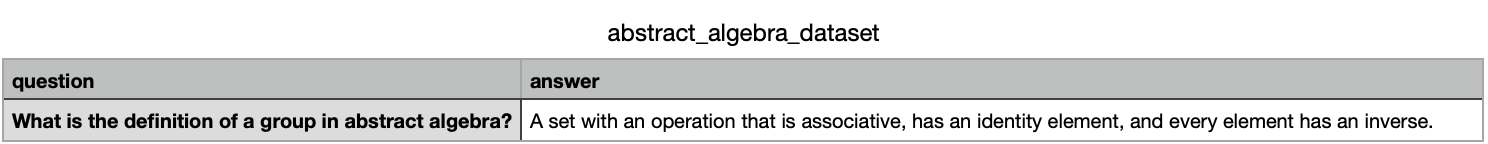

In [15]:
import pandas as pd
import os

# Set the working directory to the notebook's location
notebook_dir = '/home/jovyan/work/llm_training_experiments'
os.chdir(notebook_dir)

df = pd.read_csv("./abstract_algebra.csv")
df

,question,answer
0,What is the definition of a group in abstract ...,"A set with an operation that is associative, h..."
1,How is a ring in algebra different from a group?,A ring has two operations (addition and multip...
2,What is a field in algebra?,A field is a ring in which every non-zero elem...
3,Explain the concept of a vector space.,A vector space is a collection of vectors that...
4,What is an isomorphism in algebra?,An isomorphism is a bijective homomorphism bet...


#### Train Test Split

* Once the data has been obtained, we can split it up into training and testing data using a standard sklearn tool, [model_selection](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which splits data into random subsets for training and testing.
* When this notebook was authored, sklearn was not installed so we need to use conda to get it installed and usable within the kernel.

In [20]:
!conda install -y scikit-learn

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/envs/tf_gpu_env

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    scikit-learn-1.3.2         |   py39ha22ef79_2         8.0 MB  conda-forge
    threadpoolctl-3.2.0        |     pyha21a80b_0          20 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.2 MB

The following NEW packages will be INSTALLED:

  scikit-learn       conda-forge/linux-64::scikit-learn-1.3.2-py39ha22ef79_2
  threadpoolctl      conda-forge/noarch::thre

In [26]:
import sklearn
print(sklearn.__version__)

1.3.2


In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1)

* Once we have split the data up randomly, we can view the "train" and "test" set individually to make sure they look correct.
* This train and test split is likely to be ineffective because they have nothing to do with one another, this is merely a development test, but we're doing it as a best practice.

In [22]:
train

,question,answer
4,What is an isomorphism in algebra?,An isomorphism is a bijective homomorphism bet...
3,Explain the concept of a vector space.,A vector space is a collection of vectors that...
0,What is the definition of a group in abstract ...,"A set with an operation that is associative, h..."
2,What is a field in algebra?,A field is a ring in which every non-zero elem...


In [23]:
test

,question,answer
1,How is a ring in algebra different from a group?,A ring has two operations (addition and multip...


In [ ]:
### Config Model

* 